In [1]:
import os
import json
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, SimpleRNN

from sklearn.metrics import mean_absolute_percentage_error as MAPE

look_back = 12 
regiao = "itabuna"
forecast_horizon = 3
objeto = "cesta basica"
path = f"data/accb_custo_total_{regiao}.xlsx"

### Models

In [2]:
def model_CNN():
    model=Sequential()
    model.add(Conv1D(filters=24, kernel_size=3, input_shape=(look_back,1), activation='tanh'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(15, activation='tanh'))
    model.add(Dense(forecast_horizon))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    return model
    
def model_LSTM():
    model=Sequential()
    model.add(LSTM(32, stateful=True, input_shape=(look_back, 1), return_sequences=True, batch_input_shape=(1, look_back, 1)))
    model.add(LSTM(32,stateful=True))
    model.add(Dense(forecast_horizon))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    return model    
    
def model_RNN():
    model=Sequential()
    model.add(SimpleRNN(24, stateful=True, input_shape=(look_back, 1), batch_input_shape=(1, look_back, 1)))
    model.add(Dense(forecast_horizon))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    return model

### Train and predict

In [3]:
#Carrega os dados
cesta = pd.read_excel(path)
valores_reais = cesta.iloc[-4::, ::]
juncao_val = cesta.iloc[-4:-3:, ::]
meses_anteriores = cesta.iloc[-12:-3:, ::]
cesta.drop(['ano'], axis=1, inplace=True)
cesta = cesta / 1000
cesta = cesta.iloc[:-3:, ::]

#Cria sequencias de tempo de tamanho (meses anteriores + meses a serem previstos)
for n_step in range(1, look_back + forecast_horizon):
    cesta[f'preco t(h + {n_step})'] = cesta['preco'].shift(-n_step).values
cesta.dropna(inplace=True)
cesta.reset_index(drop=True, inplace=True)

#Divide os dados em Treino e Teste
X_train = cesta.iloc[::, :look_back:].values
y_train = cesta.iloc[::, look_back::].values
X_val = cesta.iloc[-1::, -12::].values

#remodela os dados para formato (batches, sequencia de tempo, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

forecast = {}

models = [model_RNN, model_CNN, model_LSTM]
models_names = ["RNN", "CNN", "LSTM"]

for current_model, model_name in zip(models, models_names):
    #Cria o modelo
    model = current_model()

    #Treina e prever (forecast_horizon) quantidade de tempo
    history = model.fit(X_train, y_train, epochs= 150, batch_size=1, shuffle=False, verbose=0)
    predict = model.predict(X_val, batch_size=1)[0] * 1000
    
    forecast[model_name] = []
    forecast[model_name].append(juncao_val.preco.values[0])
    
    for value in predict:
        forecast[model_name].append(value)

In [7]:
forecast_json = {}
with open(f"./data/forecast_{regiao}.json", 'r') as fd:
    forecast = json.load(fd)

for model_name in models_names:
    print(round(MAPE(valores_reais[1:].preco, forecast[model_name][1:]), 5) * 100)
    forecast_json[model_name] = [float(value) for value in forecast[model_name]]
    
""" forecast_json = json.dumps(forecast_json, indent=4)
with open(f"./data/forecast_{regiao}.json", "w") as fd:
    fd.write(forecast_json) """

0.744
0.8130000000000001
2.674


' forecast_json = json.dumps(forecast_json, indent=4)\nwith open(f"./data/forecast_{regiao}.json", "w") as fd:\n    fd.write(forecast_json) '

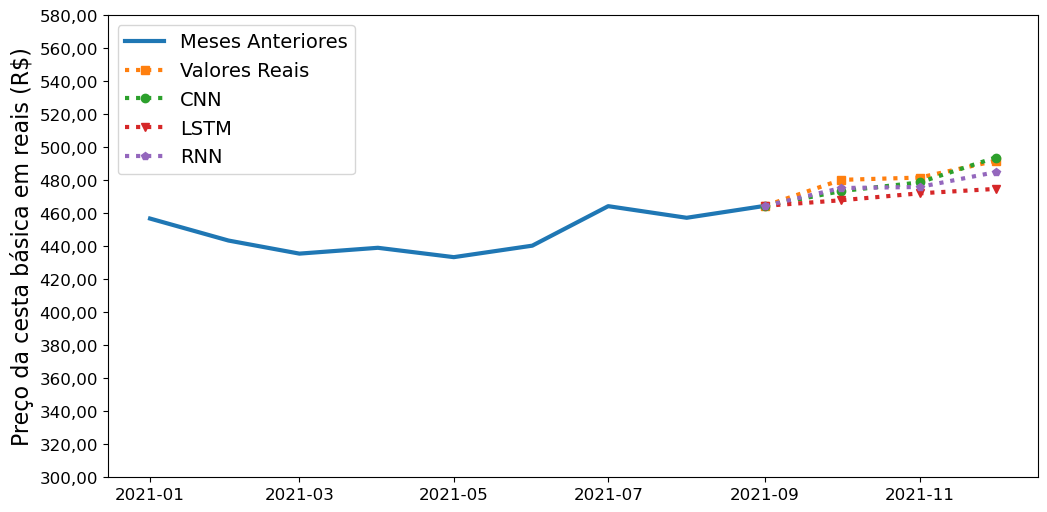

In [5]:
figure, ax = plt.subplots(figsize=(12, 6))
ax.plot(meses_anteriores.ano, meses_anteriores.preco, label='Meses Anteriores', linewidth=3)
ax.plot(valores_reais.ano, valores_reais.preco, label= "Valores Reais", linestyle="dotted", marker="s", linewidth=3)
ax.plot(valores_reais.ano, forecast['CNN'], label="CNN", linestyle="dotted", marker="o", linewidth=3)
ax.plot(valores_reais.ano, forecast['LSTM'], label="LSTM", linestyle="dotted", marker="v", linewidth=3)
ax.plot(valores_reais.ano, forecast['RNN'], label="RNN", linestyle="dotted", marker="p", linewidth=3)
ax.set_ylim(300, 580)
ax.set_yticks(range(300, 600, 20), [f"{preco},00" for preco in range(300, 600, 20)], size=12)
ax.set_ylabel("Preço da cesta básica em reais (R$)", size=16)
plt.xticks(fontsize=12)
plt.legend(loc="upper left", prop={'size': 14})
plt.savefig(f"figure/previsao_ultimos_3_meses_2021_{regiao}.png")
plt.show()